The task of the competition is to predict the category of a crime incident (e.g., Assault, Larceny/Theft, Trespass) in DC based on the time and location of the reported crime. The Washington DC Metropolitan Police Department keeps track of crime incident reports in the city and uploads them to DC OpenData for public consumption. I tried to split the data using  as test (odd weeks) and training (even weeks) sets.

In [1]:
# importing necessary libraries

# Plotting libraries/settings# Plott 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Data manipulation libraries/settings
import numpy as np
import pandas as pd
import pandas_profiling
pd.options.display.max_rows=6
pd.options.display.max_columns=10

# Machine learning library/functions
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
np.random.seed(42)

from matplotlib import rcParams
rcParams.update({'figure.autolayout':True})

# setting visual

plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/kirosgebremariam/anaconda3/envs/dsi/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
 

In [2]:
# Print version info for the sake of reproducibility
import sys
import matplotlib as mpl
import sklearn as skl
print("python " + sys.version)
print("")
print("pandas " + str(pd.__version__))
print("numpy " + np.__version__)
print("matplotlib " + mpl.__version__)
print("seaborn " + sns.__version__)
print("sklearn" + skl.__version__)

python 3.6.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]

pandas 0.23.0
numpy 1.14.3
matplotlib 2.2.2
seaborn 0.8.1
sklearn0.19.1


In [3]:
df = pd.read_csv('./input/dccrime.csv')
anc_data =pd.read_csv('./input/ancdata.csv')

In [4]:
print("-----------------")
print("Training Data Set")
print("-----------------")
df.info()

-----------------
Training Data Set
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342867 entries, 0 to 342866
Data columns (total 32 columns):
Unnamed: 0              342867 non-null int64
X                       342867 non-null int64
REPORT_DAT              342867 non-null object
SHIFT                   342867 non-null object
OFFENSE                 342867 non-null object
METHOD                  342867 non-null object
BLOCK                   342867 non-null object
DISTRICT                342667 non-null float64
PSA                     342616 non-null float64
WARD                    342867 non-null int64
ANC                     342867 non-null object
NEIGHBORHOOD_CLUSTER    338162 non-null object
BLOCK_GROUP             341776 non-null object
CENSUS_TRACT            341776 non-null float64
VOTING_PRECINCT         342783 non-null object
CCN                     342867 non-null int64
START_DATE              342854 non-null object
END_DATE                331216 non-nu

In [5]:
df.head(2)

,Unnamed: 0,X,REPORT_DAT,SHIFT,OFFENSE,...,second,EW,NS,quad,crimetype
0,1,1,8/31/2008 8:47:00 PM,EVENING,THEFT/OTHER,...,0,West,North,Northwest,Non-Violent
1,2,2,9/1/2008 12:45:00 AM,MIDNIGHT,MOTOR VEHICLE THEFT,...,0,West,North,Northwest,Non-Violent


In [6]:
df.describe()

,Unnamed: 0,X,DISTRICT,PSA,WARD,...,month,day,hour,minute,second
count,342867.000000,342867.000000,342667.000000,342616.000000,342867.000000,...,342867.000000,342867.000000,342867.000000,342867.000000,342867.000000
mean,171434.000000,171434.000000,3.727415,378.080069,4.449501,...,6.655686,15.979505,13.228853,26.294750,6.789986
std,98977.321711,98977.321711,1.977502,197.334627,2.378859,...,3.327466,8.760185,6.233693,18.106904,14.926954
...,...,...,...,...,...,...,...,...,...,...,...
50%,171434.000000,171434.000000,4.000000,401.000000,5.000000,...,7.000000,16.000000,14.000000,28.000000,0.000000
75%,257150.500000,257150.500000,5.000000,507.000000,6.000000,...,9.000000,23.000000,18.000000,42.000000,0.000000
max,342867.000000,342867.000000,7.000000,708.000000,8.000000,...,12.000000,31.000000,23.000000,59.000000,59.000000


In [7]:
df.isnull().sum()/len(df)

Unnamed: 0    0.0
X             0.0
REPORT_DAT    0.0
             ... 
NS            0.0
quad          0.0
crimetype     0.0
Length: 32, dtype: float64

In [8]:
print(df.columns.values)

['Unnamed: 0' 'X' 'REPORT_DAT' 'SHIFT' 'OFFENSE' 'METHOD' 'BLOCK'
 'DISTRICT' 'PSA' 'WARD' 'ANC' 'NEIGHBORHOOD_CLUSTER' 'BLOCK_GROUP'
 'CENSUS_TRACT' 'VOTING_PRECINCT' 'CCN' 'START_DATE' 'END_DATE' 'XBLOCK'
 'YBLOCK' 'optional' 'date' 'year' 'month' 'day' 'hour' 'minute' 'second'
 'EW' 'NS' 'quad' 'crimetype']


In [9]:
headers = df.columns.values
print(headers)

['Unnamed: 0' 'X' 'REPORT_DAT' 'SHIFT' 'OFFENSE' 'METHOD' 'BLOCK'
 'DISTRICT' 'PSA' 'WARD' 'ANC' 'NEIGHBORHOOD_CLUSTER' 'BLOCK_GROUP'
 'CENSUS_TRACT' 'VOTING_PRECINCT' 'CCN' 'START_DATE' 'END_DATE' 'XBLOCK'
 'YBLOCK' 'optional' 'date' 'year' 'month' 'day' 'hour' 'minute' 'second'
 'EW' 'NS' 'quad' 'crimetype']


In [10]:
for i, j in enumerate(headers):
    print('{} : {}'.format(i,j))

0 : Unnamed: 0
1 : X
2 : REPORT_DAT
3 : SHIFT
4 : OFFENSE
5 : METHOD
6 : BLOCK
7 : DISTRICT
8 : PSA
9 : WARD
10 : ANC
11 : NEIGHBORHOOD_CLUSTER
12 : BLOCK_GROUP
13 : CENSUS_TRACT
14 : VOTING_PRECINCT
15 : CCN
16 : START_DATE
17 : END_DATE
18 : XBLOCK
19 : YBLOCK
20 : optional
21 : date
22 : year
23 : month
24 : day
25 : hour
26 : minute
27 : second
28 : EW
29 : NS
30 : quad
31 : crimetype


In [11]:
print(df.shape)
print(df.head(3))

(342867, 32)
   Unnamed: 0  X            REPORT_DAT     SHIFT              OFFENSE  \
0           1  1  8/31/2008 8:47:00 PM   EVENING          THEFT/OTHER   
1           2  2  9/1/2008 12:45:00 AM  MIDNIGHT  MOTOR VEHICLE THEFT   
2           3  3   9/1/2008 3:00:00 AM  MIDNIGHT          THEFT/OTHER   

      ...      second    EW     NS       quad    crimetype  
0     ...           0  West  North  Northwest  Non-Violent  
1     ...           0  West  North  Northwest  Non-Violent  
2     ...           0  East  North  Northeast  Non-Violent  

[3 rows x 32 columns]


In [12]:
pandas_profiling.ProfileReport(df)

Number of variables,32
Number of observations,342867
Total Missing (%),0.2%
Total size in memory,81.4 MiB
Average record size in memory,249.0 B
Numeric,12
Categorical,16
Boolean,0
Date,0
Text (Unique),0
Rejected,4


In [13]:
pandas_profiling.ProfileReport(anc_data)

Number of variables,6
Number of observations,85
Total Missing (%),0.0%
Total size in memory,4.1 KiB
Average record size in memory,48.9 B
Numeric,4
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [14]:
for item in df:
    print (item)
    print (df[item].nunique())

Unnamed: 0
342867
X
342867
REPORT_DAT
312606
SHIFT
3
OFFENSE
9
METHOD
3
BLOCK
17617
DISTRICT
7
PSA
56
WARD
8
ANC
40
NEIGHBORHOOD_CLUSTER
39
BLOCK_GROUP
450
CENSUS_TRACT
179
VOTING_PRECINCT
143
CCN
342766
START_DATE
267071
END_DATE
273259
XBLOCK
18169
YBLOCK
17999
optional
1
date
312606
year
10
month
12
day
31
hour
24
minute
60
second
60
EW
2
NS
2
quad
4
crimetype
2


In [15]:
for item in anc_data:
    print (item)
    print (anc_data[item].nunique())

YR
8
ANC
40
ANC2
40
ANC3
40
Housing_Prices
80
Unemployment
34


In [16]:
df.columns

Index(['Unnamed: 0', 'X', 'REPORT_DAT', 'SHIFT', 'OFFENSE', 'METHOD', 'BLOCK',
       'DISTRICT', 'PSA', 'WARD', 'ANC', 'NEIGHBORHOOD_CLUSTER', 'BLOCK_GROUP',
       'CENSUS_TRACT', 'VOTING_PRECINCT', 'CCN', 'START_DATE', 'END_DATE',
       'XBLOCK', 'YBLOCK', 'optional', 'date', 'year', 'month', 'day', 'hour',
       'minute', 'second', 'EW', 'NS', 'quad', 'crimetype'],
      dtype='object')

In [17]:
anc_data.columns

Index(['YR', 'ANC', 'ANC2', 'ANC3', 'Housing_Prices', 'Unemployment'], dtype='object')

In [18]:
print("Number of unique crime categories:", len(df['BLOCK'].unique()))
print("")
print(df['BLOCK'].unique())

Number of unique crime categories: 17617

['3500 - 3599 BLOCK OF R STREET NW' '2000 - 2015 BLOCK OF O STREET NW'
 '700 - 799 BLOCK OF 11TH STREET NW' ...
 'OTIS PLACE NW AND OGDEN STREET NW' 'U STREET NW AND 4TH STREET NW'
 'PINEY BRANCH PARKWAY NW AND 17TH STREET NW']


In [19]:
df.groupby('BLOCK').OFFENSE.value_counts(normalize=True)

BLOCK                                        OFFENSE                   
0 - 0 BLOCK OF 14TH STREET SW                ROBBERY                       0.500000
                                             THEFT/OTHER                   0.500000
0 - 0 BLOCK OF ARLINGTON MEMORIAL BRIDGE SW  THEFT F/AUTO                  0.500000
                                                                             ...   
YUMA STREET SE AND 9TH STREET SE             MOTOR VEHICLE THEFT           0.333333
                                             ROBBERY                       0.333333
YUMA STREET SE AND CONDON TERRACE SE         ASSAULT W/DANGEROUS WEAPON    1.000000
Name: OFFENSE, Length: 60539, dtype: float64

In [20]:
df.groupby('crimetype').OFFENSE.value_counts()

crimetype    OFFENSE                   
Non-Violent  THEFT/OTHER                   130435
             THEFT F/AUTO                   85287
             MOTOR VEHICLE THEFT            33188
                                            ...  
Violent      ASSAULT W/DANGEROUS WEAPON     23436
             SEX ABUSE                       2402
             HOMICIDE                        1234
Name: OFFENSE, Length: 9, dtype: int64

In [21]:
df.describe()

,Unnamed: 0,X,DISTRICT,PSA,WARD,...,month,day,hour,minute,second
count,342867.000000,342867.000000,342667.000000,342616.000000,342867.000000,...,342867.000000,342867.000000,342867.000000,342867.000000,342867.000000
mean,171434.000000,171434.000000,3.727415,378.080069,4.449501,...,6.655686,15.979505,13.228853,26.294750,6.789986
std,98977.321711,98977.321711,1.977502,197.334627,2.378859,...,3.327466,8.760185,6.233693,18.106904,14.926954
...,...,...,...,...,...,...,...,...,...,...,...
50%,171434.000000,171434.000000,4.000000,401.000000,5.000000,...,7.000000,16.000000,14.000000,28.000000,0.000000
75%,257150.500000,257150.500000,5.000000,507.000000,6.000000,...,9.000000,23.000000,18.000000,42.000000,0.000000
max,342867.000000,342867.000000,7.000000,708.000000,8.000000,...,12.000000,31.000000,23.000000,59.000000,59.000000


In [22]:
df.corr()  

,Unnamed: 0,X,DISTRICT,PSA,WARD,...,month,day,hour,minute,second
Unnamed: 0,1.000000,1.000000,0.444360,0.446906,0.269324,...,-0.002029,0.006044,-0.028368,0.001903,0.025989
X,1.000000,1.000000,0.444360,0.446906,0.269324,...,-0.002029,0.006044,-0.028368,0.001903,0.025989
DISTRICT,0.444360,0.444360,1.000000,0.993374,0.591368,...,0.002397,0.006476,-0.041199,-0.005852,-0.020731
...,...,...,...,...,...,...,...,...,...,...,...
hour,-0.028368,-0.028368,-0.041199,-0.041736,-0.021544,...,-0.005826,0.003839,1.000000,0.004603,0.014664
minute,0.001903,0.001903,-0.005852,-0.006190,-0.006409,...,0.000140,0.003176,0.004603,1.000000,0.081377
second,0.025989,0.025989,-0.020731,-0.022580,-0.009984,...,0.044295,0.006159,0.014664,0.081377,1.000000


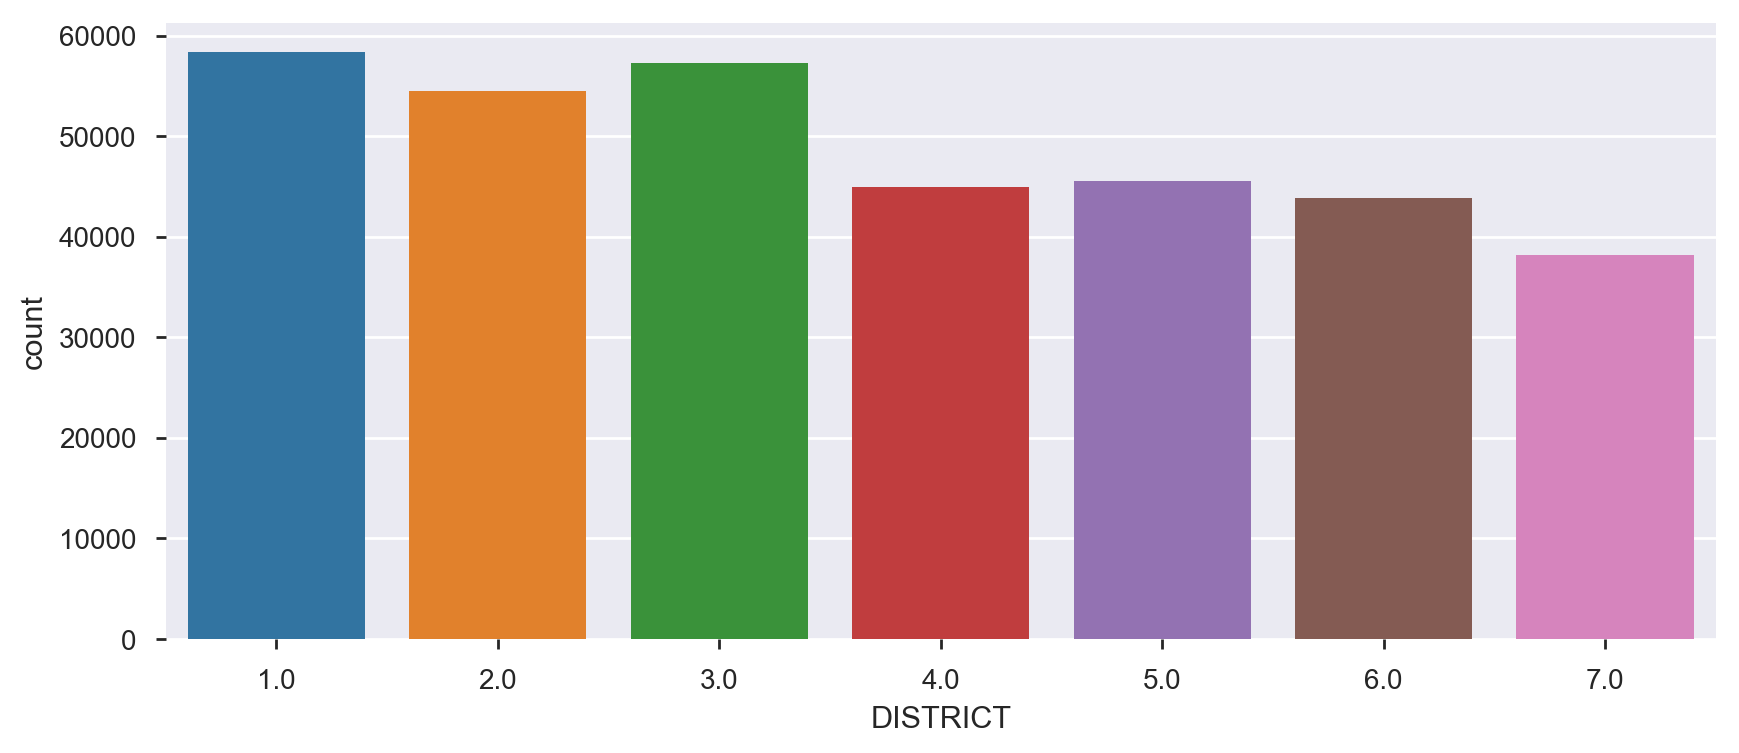

In [23]:
fig,ax =plt.subplots(figsize=(10, 4))
sns.countplot(x='DISTRICT', data=df, ax=ax)

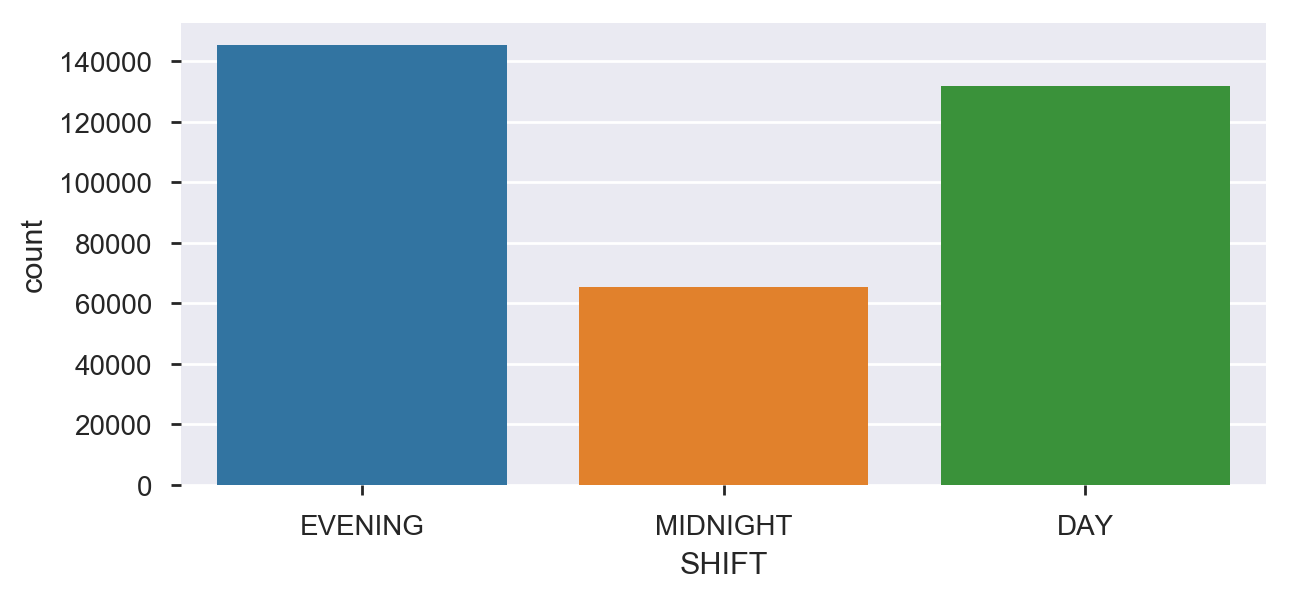

In [24]:
fig, ax = plt.subplots(figsize=(7, 3))
sns.countplot(x='SHIFT', data=df, ax=ax)

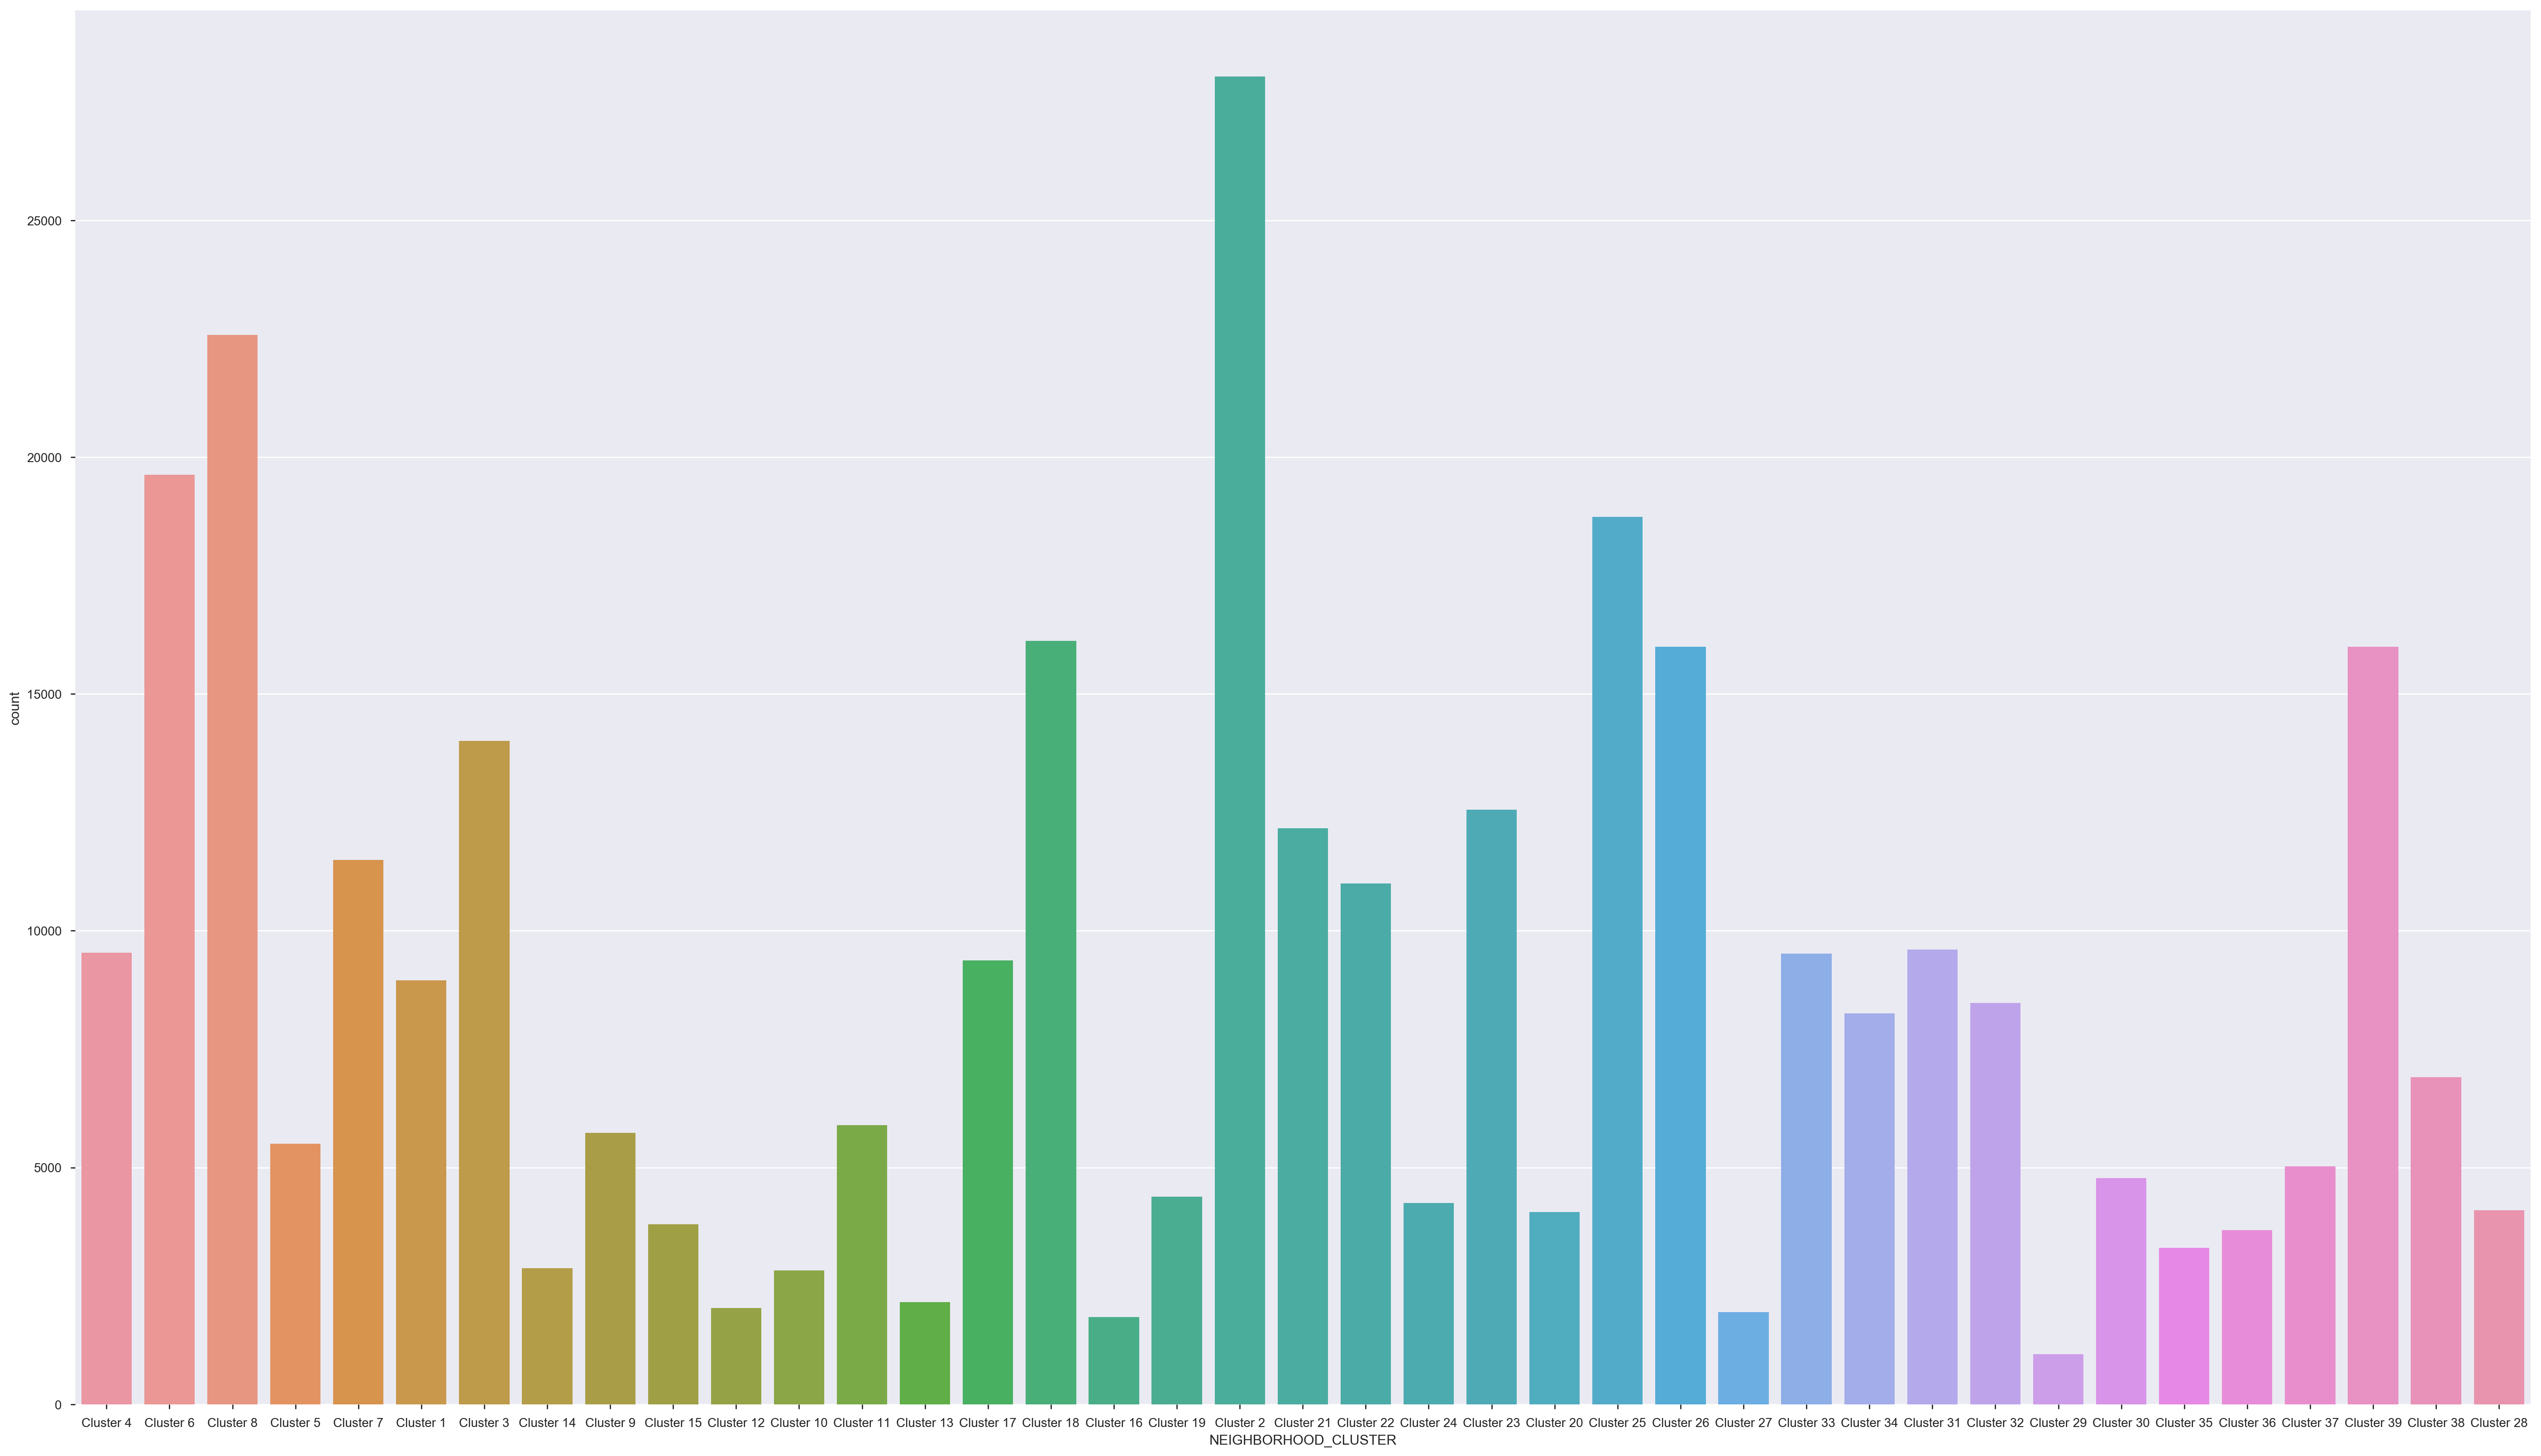

In [25]:
fig, ax = plt.subplots(figsize=(35, 20))
sns.countplot(x='NEIGHBORHOOD_CLUSTER', data=df, ax=ax)

In [26]:
print("Number of unique addresses:", len(df['WARD'].unique()))

Number of unique addresses: 8


In [27]:
print("Number of unique addresses:", len(df['SHIFT'].unique()))

Number of unique addresses: 3


In [28]:
df.columns

Index(['Unnamed: 0', 'X', 'REPORT_DAT', 'SHIFT', 'OFFENSE', 'METHOD', 'BLOCK',
       'DISTRICT', 'PSA', 'WARD', 'ANC', 'NEIGHBORHOOD_CLUSTER', 'BLOCK_GROUP',
       'CENSUS_TRACT', 'VOTING_PRECINCT', 'CCN', 'START_DATE', 'END_DATE',
       'XBLOCK', 'YBLOCK', 'optional', 'date', 'year', 'month', 'day', 'hour',
       'minute', 'second', 'EW', 'NS', 'quad', 'crimetype'],
      dtype='object')

In [29]:
df.XBLOCK.head()

0   -77.070209
1   -77.045323
2   -77.027045
3   -77.040089
4   -77.019377
Name: XBLOCK, dtype: float64

In [30]:
df.YBLOCK.head()

0    38.913633
1    38.908564
2    38.899057
3    38.909638
4    38.894573
Name: YBLOCK, dtype: float64

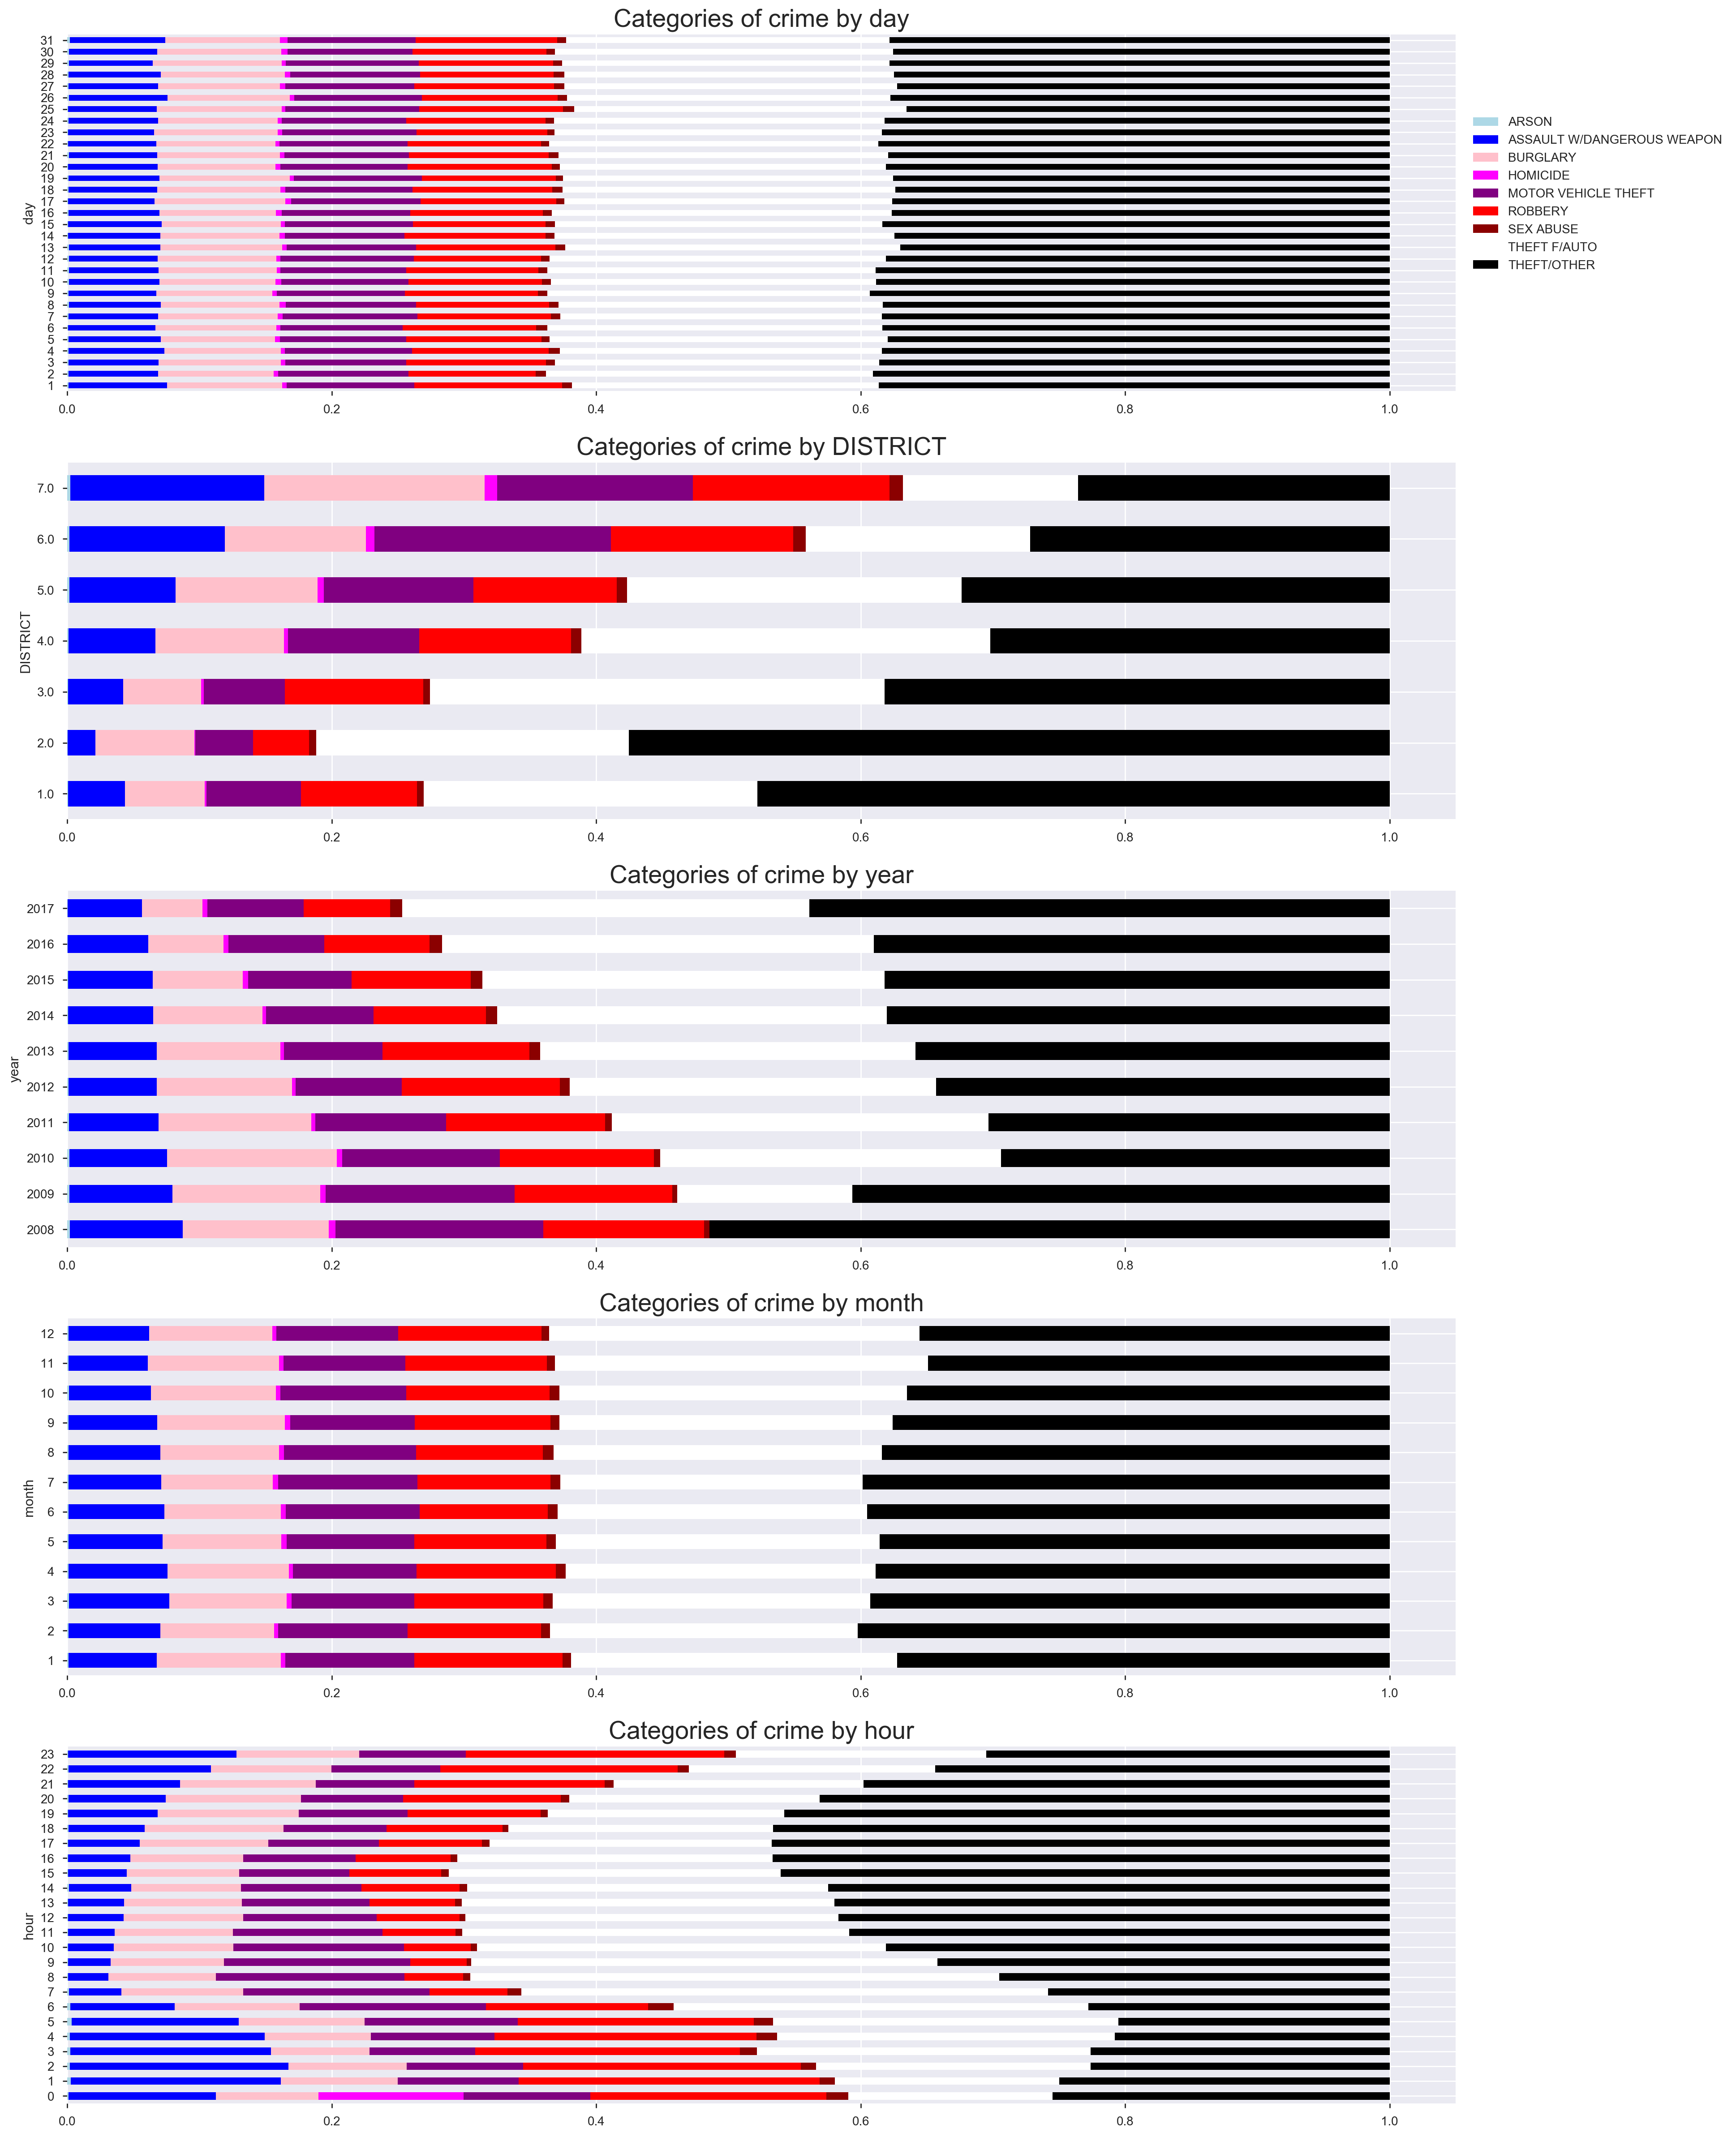

In [31]:
def proportionCrimeCategory(data, discreteParam):
    """
    Extracts proportion of Crimes in the data for the various values of discreteParam
    :param data: input dataframe
    :param discreteParam: name of column of dataframe 
    :return normedtable: Series
            column 1 : index of month
            column 2 : sum of crimes during this month/total numbers of crimes
    """
    by_param = data.groupby([discreteParam, 'OFFENSE'])
    #apllying .size() allows to extract number of instances for each Crime type by the offense in each discreteParam
    table = by_param.size()
    #puts it as a 2D table with number of occurences per discreteParam and Crimetype
    d2table = table.unstack()
    #d2table.sum(1) returns the number of crimes in all crimetypes per discreteParam
    #1 is for the number of the axe on which the sum is done. Here :Crimetype
    normedtable = d2table.div(d2table.sum(1), axis=0)
    return normedtable
    print(normedtable)
    
discreteParamList = ['day', 'DISTRICT', 'year','month','hour']
fig1, axes1 = plt.subplots(len(discreteParamList),1) #creates a 3x1 blank plot
for i in range(len(discreteParamList)): #now we fill in the subplots
    param = discreteParamList[i]
    table = proportionCrimeCategory(df, param)

    ax = axes1[i]
    #create plot title
    ax.set_title("Categories of crime by %s" % discreteParamList[i])
    ax.title.set_fontsize(20)
    #choose colormap (memo : looks ok : none, prism_r)
    #stacked = true, allows to stack the different categories into one bar
    table.plot(kind='barh', stacked=True, ax=axes1[i],figsize=(20,30), color=['lightblue','blue','pink','magenta', 'purple', 'red', 'darkred', 'white', 'black','turquoise'])

    #Puts legend only on second graph and pushes the legend out of plot
    if i==1:
        #how to move legends : http://matplotlib.org/examples/pylab_examples/legend_demo3.html
        ax.legend(bbox_to_anchor=(1.2, 2))

    else:
        ax.legend_.remove()
plt.savefig("input/proportions.pdf",format="pdf")